In [1]:
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import modin.pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
from modin.config import ProgressBar
from tqdm import tqdm

# import seaborn as sns

ProgressBar.enable()

In [2]:
df = (
    pd.read_parquet("wforms-occ.parquet", columns=["fst", "lst", "tot", "rho"])
    .add_suffix("_occ")
    .join(
        pd.read_parquet("wforms-usr.parquet", columns=["tot", "rho"]).add_suffix("_usr")
    )
)

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2023-07-29 13:25:11,348	INFO worker.py:1636 -- Started a local Ray instance.


Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

In [3]:
ft = (df["fst_occ"] > 7) & (df["lst_occ"] > 354) & (df["lst_occ"] - df["fst_occ"] > 28)
fc = (df["tot_usr"] > 9) & (df["tot_occ"] > 9)
fg = df["rho_occ"].gt(0.2)
fa = abs(df["rho_occ"]).gt(0.2) | abs(df["rho_usr"]).gt(0.2)

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 4:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 98:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 100:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 127:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 128:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 152:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 153:   0%           Elapsed time: 00:00, estimated remaining time: ?

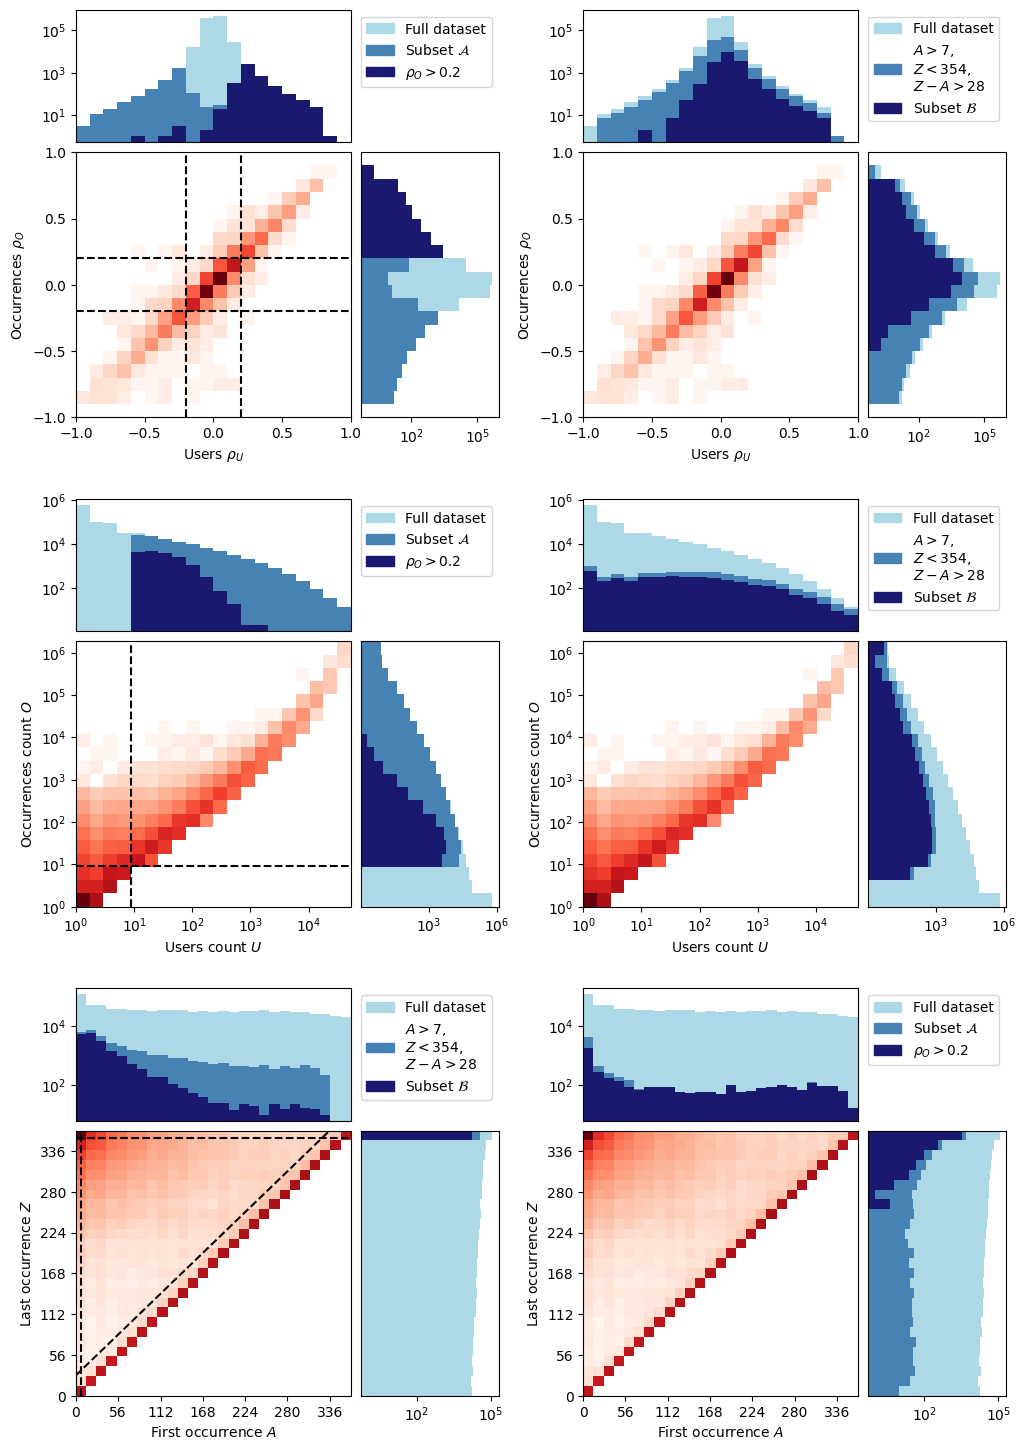

In [32]:
style_line = {"color": "k", "linestyle": "--"}
style_hist = {"cmap": "Reds"}
style_marg = {"log": True, "align": "mid"}
s_gridspec = {
    "width_ratios": (4, 2),
    "height_ratios": (2, 4),
    "wspace": 0.05,
    "hspace": 0.05,
}
tick_margx = {
    "axis": "x",
    "which": "both",
    "bottom": False,
    "top": False,
    "labelbottom": False,
}
tick_margy = {
    "axis": "y",
    "which": "both",
    "left": False,
    "right": False,
    "labelleft": False,
}
marg_cols = ["lightblue", "steelblue", "midnightblue"]

# ===============================================================================

fig = plt.figure(figsize=(6 * 2, 6 * 3))

ggs = gridspec.GridSpec(
    3,
    2,
    width_ratios=(1, 1),
    height_ratios=(1, 1, 1),
    wspace=0.2,
    hspace=0.2,
    figure=fig,
)

# ===============================================================================

gs = gridspec.GridSpecFromSubplotSpec(2, 2, **s_gridspec, subplot_spec=ggs[0, 0])
ax00_hist2d = fig.add_subplot(gs[1, 0])
ax00_marg_x = fig.add_subplot(gs[0, 0], sharex=ax00_hist2d)
ax00_marg_y = fig.add_subplot(gs[1, 1], sharey=ax00_hist2d)
ax00_legend = fig.add_subplot(gs[0, 1])

counts, xedges, yedges = np.histogram2d(
    df["rho_usr"], df["rho_occ"], bins=np.linspace(-1, 1, 20 + 1)
)
ax00_hist2d.pcolormesh(xedges, yedges, counts.T, norm=colors.LogNorm(), **style_hist)

ax00_hist2d.axvline(x=+0.2, **style_line)
ax00_hist2d.axvline(x=-0.2, **style_line)
ax00_hist2d.axhline(y=+0.2, **style_line)
ax00_hist2d.axhline(y=-0.2, **style_line)

style = {**style_marg, "color": marg_cols[0]}
ax00_marg_x.hist(df["rho_usr"], bins=xedges, **style)
ax00_marg_y.hist(df["rho_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(False)
style = {**style_marg, "color": marg_cols[1]}
ax00_marg_x.hist(df[fa]["rho_usr"], bins=xedges, **style)
ax00_marg_y.hist(df[fa]["rho_occ"], bins=yedges, **style, orientation="horizontal")
style = {**style_marg, "color": marg_cols[2]}
ax00_marg_x.hist(df[fg]["rho_usr"], bins=xedges, **style)
ax00_marg_y.hist(df[fg]["rho_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(True)

# ===============================================================================

gs = gridspec.GridSpecFromSubplotSpec(2, 2, **s_gridspec, subplot_spec=ggs[1, 0])
ax10_hist2d = fig.add_subplot(gs[1, 0])
ax10_marg_x = fig.add_subplot(gs[0, 0], sharex=ax10_hist2d)
ax10_marg_y = fig.add_subplot(gs[1, 1], sharey=ax10_hist2d)
ax10_legend = fig.add_subplot(gs[0, 1])

counts, xedges, yedges = np.histogram2d(
    np.log10(df["tot_usr"]), np.log10(df["tot_occ"]), bins=20
)
ax10_hist2d.pcolormesh(xedges, yedges, counts.T, norm=colors.LogNorm(), **style_hist)

ax10_hist2d.axvline(x=np.log10(9), **style_line)
ax10_hist2d.axhline(y=np.log10(9), **style_line)

style = {**style_marg, "color": marg_cols[0]}
ax10_marg_x.hist(np.log10(df["tot_usr"]), bins=xedges, **style)
ax10_marg_y.hist(
    np.log10(df["tot_occ"]), bins=yedges, **style, orientation="horizontal"
)
plt.autoscale(False)
style = {**style_marg, "color": marg_cols[1]}
ax10_marg_x.hist(np.log10(df[fc]["tot_usr"]), bins=xedges, **style)
ax10_marg_y.hist(
    np.log10(df[fc]["tot_occ"]), bins=yedges, **style, orientation="horizontal"
)
style = {**style_marg, "color": marg_cols[2]}
ax10_marg_x.hist(np.log10(df[fc & ft]["tot_usr"]), bins=xedges, **style)
ax10_marg_y.hist(
    np.log10(df[fc & ft]["tot_occ"]), bins=yedges, **style, orientation="horizontal"
)
plt.autoscale(True)

# ===============================================================================

gs = gridspec.GridSpecFromSubplotSpec(2, 2, **s_gridspec, subplot_spec=ggs[2, 0])
ax20_hist2d = fig.add_subplot(gs[1, 0])
ax20_marg_x = fig.add_subplot(gs[0, 0], sharex=ax20_hist2d)
ax20_marg_y = fig.add_subplot(gs[1, 1], sharey=ax20_hist2d)
ax20_legend = fig.add_subplot(gs[0, 1])

counts, xedges, yedges = np.histogram2d(df["fst_occ"], df["lst_occ"], bins=55 // 2)
ax20_hist2d.pcolormesh(xedges, yedges, counts.T, norm=colors.LogNorm(), **style_hist)

ax20_hist2d.axvline(x=7, **style_line)
ax20_hist2d.axhline(y=354, **style_line)
ax20_hist2d.axline((0, 28), slope=1, **style_line)

style = {**style_marg, "color": marg_cols[0]}
ax20_marg_x.hist(df["fst_occ"], bins=xedges, **style)
ax20_marg_y.hist(df["lst_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(False)
style = {**style_marg, "color": marg_cols[1]}
ax20_marg_x.hist(df[ft]["fst_occ"], bins=xedges, **style)
ax20_marg_y.hist(df[ft]["lst_occ"], bins=yedges, **style, orientation="horizontal")
style = {**style_marg, "color": marg_cols[2]}
ax20_marg_x.hist(df[ft & fc]["fst_occ"], bins=xedges, **style)
ax20_marg_y.hist(df[ft & fc]["lst_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(True)

# ===============================================================================

gs = gridspec.GridSpecFromSubplotSpec(2, 2, **s_gridspec, subplot_spec=ggs[0, 1])
ax01_hist2d = fig.add_subplot(gs[1, 0])
ax01_marg_x = fig.add_subplot(gs[0, 0], sharex=ax01_hist2d)
ax01_marg_y = fig.add_subplot(gs[1, 1], sharey=ax01_hist2d)
ax01_legend = fig.add_subplot(gs[0, 1])

counts, xedges, yedges = np.histogram2d(
    df["rho_usr"], df["rho_occ"], bins=np.linspace(-1, 1, 20 + 1)
)
ax01_hist2d.pcolormesh(xedges, yedges, counts.T, norm=colors.LogNorm(), **style_hist)

style = {**style_marg, "color": marg_cols[0]}
ax01_marg_x.hist(df["rho_usr"], bins=xedges, **style)
ax01_marg_y.hist(df["rho_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(False)
style = {**style_marg, "color": marg_cols[1]}
ax01_marg_x.hist(df[fc]["rho_usr"], bins=xedges, **style)
ax01_marg_y.hist(df[fc]["rho_occ"], bins=yedges, **style, orientation="horizontal")
style = {**style_marg, "color": marg_cols[2]}
ax01_marg_x.hist(df[fc & ft]["rho_usr"], bins=xedges, **style)
ax01_marg_y.hist(df[fc & ft]["rho_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(True)

# ===============================================================================

gs = gridspec.GridSpecFromSubplotSpec(2, 2, **s_gridspec, subplot_spec=ggs[1, 1])
ax11_hist2d = fig.add_subplot(gs[1, 0])
ax11_marg_x = fig.add_subplot(gs[0, 0], sharex=ax11_hist2d)
ax11_marg_y = fig.add_subplot(gs[1, 1], sharey=ax11_hist2d)
ax11_legend = fig.add_subplot(gs[0, 1])

counts, xedges, yedges = np.histogram2d(
    np.log10(df["tot_usr"]), np.log10(df["tot_occ"]), bins=20
)
ax11_hist2d.pcolormesh(xedges, yedges, counts.T, norm=colors.LogNorm(), **style_hist)

style = {**style_marg, "color": marg_cols[0]}
ax11_marg_x.hist(np.log10(df["tot_usr"]), bins=xedges, **style)
ax11_marg_y.hist(
    np.log10(df["tot_occ"]), bins=yedges, **style, orientation="horizontal"
)
plt.autoscale(False)
style = {**style_marg, "color": marg_cols[1]}
ax11_marg_x.hist(np.log10(df[fa]["tot_usr"]), bins=xedges, **style)
ax11_marg_y.hist(
    np.log10(df[fa]["tot_occ"]), bins=yedges, **style, orientation="horizontal"
)
style = {**style_marg, "color": marg_cols[2]}
ax11_marg_x.hist(np.log10(df[fg]["tot_usr"]), bins=xedges, **style)
ax11_marg_y.hist(
    np.log10(df[fg]["tot_occ"]), bins=yedges, **style, orientation="horizontal"
)
plt.autoscale(True)

# ===============================================================================

gs = gridspec.GridSpecFromSubplotSpec(2, 2, **s_gridspec, subplot_spec=ggs[2, 1])
ax21_hist2d = fig.add_subplot(gs[1, 0])
ax21_marg_x = fig.add_subplot(gs[0, 0], sharex=ax21_hist2d)
ax21_marg_y = fig.add_subplot(gs[1, 1], sharey=ax21_hist2d)
ax21_legend = fig.add_subplot(gs[0, 1])

counts, xedges, yedges = np.histogram2d(df["fst_occ"], df["lst_occ"], bins=55 // 2)
ax21_hist2d.pcolormesh(xedges, yedges, counts.T, norm=colors.LogNorm(), **style_hist)

style = {**style_marg, "color": marg_cols[0]}
ax21_marg_x.hist(df["fst_occ"], bins=xedges, **style)
ax21_marg_y.hist(df["lst_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(False)
style = {**style_marg, "color": marg_cols[1]}
ax21_marg_x.hist(df[fa]["fst_occ"], bins=xedges, **style)
ax21_marg_y.hist(df[fa]["lst_occ"], bins=yedges, **style, orientation="horizontal")
style = {**style_marg, "color": marg_cols[2]}
ax21_marg_x.hist(df[fg]["fst_occ"], bins=xedges, **style)
ax21_marg_y.hist(df[fg]["lst_occ"], bins=yedges, **style, orientation="horizontal")
plt.autoscale(True)

# ===============================================================================

for ax in [ax00_hist2d, ax01_hist2d]:
    ax.set_xlim((-1, 1))
    ax.set_ylim((-1, 1))
    ax.set_xticks(np.linspace(-1, 1, 5))
    ax.set_yticks(np.linspace(-1, 1, 5))
    ax.set_xlabel("Users $\\rho_U$")
    ax.set_ylabel("Occurrences $\\rho_O$")

formatter = FuncFormatter(lambda value, tick_number: f"$10^{value:.0f}$")
for ax in [ax11_hist2d, ax10_hist2d]:
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)
    ax.set_xlabel("Users count $U$")
    ax.set_ylabel("Occurrences count $O$")

for ax in [ax20_hist2d, ax21_hist2d]:
    ax.set_xlim((0, 364))
    ax.set_ylim((0, 364))
    ax.set_xticks(np.arange(0, 364, 7 * 8))
    ax.set_yticks(np.arange(0, 364, 7 * 8))
    ax.set_xlabel("First occurrence $A$")
    ax.set_ylabel("Last occurrence $Z$")

for ax in [
    ax01_marg_x,
    ax11_marg_x,
    ax21_marg_x,
    ax20_marg_x,
    ax10_marg_x,
    ax00_marg_x,
]:
    ax.tick_params(**tick_margx)

for ax in [
    ax01_marg_y,
    ax11_marg_y,
    ax21_marg_y,
    ax20_marg_y,
    ax10_marg_y,
    ax00_marg_y,
]:
    ax.tick_params(**tick_margy)

for axs in [
    [ax00_marg_y, ax01_marg_y],
    [ax10_marg_y, ax11_marg_y],
    [ax20_marg_y, ax21_marg_y],
]:
    lims = np.array([ax.get_xlim() for ax in axs]).T
    xlim = (lims[0].min(), lims[1].max())
    for ax in axs:
        ax.set_xlim(xlim)

for axs in [
    [ax00_marg_x, ax01_marg_x],
    [ax10_marg_x, ax11_marg_x],
    [ax20_marg_x, ax21_marg_x],
]:
    lims = np.array([ax.get_ylim() for ax in axs]).T
    ylim = (lims[0].min(), lims[1].max())
    for ax in axs:
        ax.set_ylim(ylim)

# ax20_marg_y.set_xticks([10**4, 10**5])
# ax21_marg_y.set_xticks([10**4, 10**5])

for ax in [ax01_legend, ax11_legend, ax20_legend]:
    ax.axis("off")
    ax.legend(
        handles=[
            mpatches.Patch(color=marg_cols[0], label="Full dataset"),
            mpatches.Patch(color=marg_cols[1], label="$A>7$,\n$Z<354$,\n$Z-A>28$"),
            mpatches.Patch(color=marg_cols[2], label="Subset $\mathcal{B}$"),
        ],
        loc="upper right",
    )

for ax in [ax00_legend, ax10_legend, ax21_legend]:
    ax.axis("off")
    ax.legend(
        handles=[
            mpatches.Patch(color=marg_cols[0], label="Full dataset"),
            mpatches.Patch(color=marg_cols[1], label="Subset $\mathcal{A}$"),
            mpatches.Patch(color=marg_cols[2], label="$\\rho_O>0.2$"),
        ],
        loc="upper right",
    )

# ===============================================================================

plt.savefig("subsets.pdf", format="pdf", bbox_inches="tight")
plt.show()